In [1]:
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import torch
import os
from pathlib import Path
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
os.environ["HF_HOME"]

'/buckets/datasets/huggingface'

In [2]:
# model_name = "HuggingFaceTB/SmolLM3-3B"
# model_name = "Qwen/Qwen3-1.7B"
model_name = "Qwen/Qwen3-8B"

In [3]:
teacher = AutoModelForCausalLM.from_pretrained(
    model_name,
    #   dtype="bfloat16",
    #   device_map="auto"
    dtype="auto",
    device_map="auto",
)
# .cuda()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
print(teacher.model.embed_tokens.weight.numel()/1000**2)
print(sum(p.numel() for n,p in teacher.model.named_parameters() if "self_attn" in  n)/1000**2)
print(sum(p.numel() for n,p in teacher.model.named_parameters() if "mlp" in  n)/1000**2)
print(teacher.lm_head.weight.numel()/1000**2)

622.329856
1509.958656
5435.817984
622.329856


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# student = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     dtype="bfloat16",
#     device_map="auto",
# )

In [7]:
student = teacher

In [8]:
student

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attention_la

In [9]:
from datasets import load_dataset

In [10]:
# en = load_dataset("allenai/c4", "en", streaming=True)

In [11]:
# multilingual = load_dataset("allenai/c4", "multilingual", streaming=True)

In [12]:
ds = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')

In [13]:
wikitext = " ".join(ds["text"])

In [14]:
len(wikitext)

10929707

In [15]:
seq_length = 512
num_samples = 256

In [16]:
input_text = []
for i in range(num_samples):
    input_text.append(wikitext[i*seq_length:(i+1)*seq_length])

In [17]:
tokenized_inputs = [
    tokenizer([text], return_tensors="pt", return_token_type_ids=False)
    for text in input_text
]

In [18]:
from bonsainet.hooks import ModuleInputCatcher, ModuleOutputCatcher

In [19]:
input_catcher = ModuleInputCatcher(device=torch.device("cpu"))
output_catcher = ModuleOutputCatcher(device=torch.device("cpu"))

In [20]:
student

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attention_la

In [21]:
prev_layers = list(range(0,5))
layer_idx = len(prev_layers)
# layer_idx = 0
layer_name = f"decoder_{layer_idx}"
print(prev_layers, layer_idx, layer_name)


[0, 1, 2, 3, 4] 5 decoder_5


In [22]:
layer_idx = 0

In [23]:
teacher_layer = teacher.model.layers[layer_idx]#.self_attn
output_catcher.attach(teacher_layer, layer_name)

In [24]:
with torch.no_grad():
    for model_inputs in tqdm(tokenized_inputs):
        _  = teacher(**model_inputs.to(teacher.device), labels=None, use_cache=False)

100%|██████████| 256/256 [00:13<00:00, 18.88it/s]


In [25]:
layer_targets = output_catcher.outputs[layer_name]

In [26]:
output_catcher.detach(layer_name)

In [27]:
student_layer = student.model.layers[layer_idx]#.self_attn

In [28]:
list(Path(f"/buckets/checkpoints/{model_name}").parent.glob("*.*"))

[PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_8.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_4.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_1.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_5.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_6.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_2.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_3.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_7.cpt'),
 PosixPath('/buckets/checkpoints/Qwen/Qwen3-8B_decoder_0.cpt')]

In [30]:
for prev_l in prev_layers:
    layer_ckpt_path = Path(f"/buckets/checkpoints/{model_name}_decoder_{prev_l}.cpt")
    print(layer_ckpt_path)
    student.model.layers[prev_l].load_state_dict(torch.load(layer_ckpt_path))

/buckets/checkpoints/Qwen/Qwen3-8B_decoder_0.cpt
/buckets/checkpoints/Qwen/Qwen3-8B_decoder_1.cpt
/buckets/checkpoints/Qwen/Qwen3-8B_decoder_2.cpt
/buckets/checkpoints/Qwen/Qwen3-8B_decoder_3.cpt
/buckets/checkpoints/Qwen/Qwen3-8B_decoder_4.cpt


In [28]:
# teacher.seq_len

In [29]:
input_catcher.attach(student_layer,layer_name)

In [30]:
# student_layer.load_state_dict(teacher_layer.state_dict())

In [31]:
with torch.no_grad():
    for model_inputs in tqdm(tokenized_inputs):
        # _  = teacher(**model_inputs.to(teacher.device), labels=None, use_cache=False)
        _  = student(**model_inputs.to(teacher.device), labels=None, use_cache=False)
        
        # layer_inputs.append(iocatcher.inputs["layer_0"])
        # layer_outputs.append(iocatcher.outputs["layer_0"])

100%|██████████| 256/256 [00:13<00:00, 19.32it/s]


In [32]:
layer_inputs = input_catcher.inputs[layer_name]
# layer_targets = output_catcher.outputs[layer_name]

In [33]:
input_catcher.detach(layer_name)

In [34]:
# del(teacher)
torch.cuda.empty_cache()

In [35]:
# student.model.layers[layer_idx].load_state_dict(teacher.model.layers[layer_idx].state_dict())

In [36]:
# from deepspeed.ops.adam import DeepSpeedCPUAdam

In [37]:
# optimizer = DeepSpeedCPUAdam(model.parameters(),lr=1e-4, adamw_mode=False, weight_decay=1e-4)

In [38]:
# import deepspeed

In [39]:

# ds_config = {
#     "train_batch_size": 2,
#     "gradient_accumulation_steps": 2,
#     # "optimizer": {
#     #     "type": "DeepSpeedCPUAdam",
#     #     "params": {
#     #         "lr": 1e-4,
#     #         "adamw_mode": False,
#     #         "weight_decay": 1e-4
#     #     }
#     # },
#     "zero_optimization": {
#         "stage": 2,          # or 3
#         "offload_optimizer": {
#             "device": "cpu", # optimizer step is done on CPU
#             "pin_memory": True
#         }
#     }
# }

# model_engine, optimizer, _, _ = deepspeed.initialize(
#     model=model,
#     # model_parameters=model.parameters(),
#     config=ds_config,
#     optimizer=optimizer,
# )

In [40]:
# outs = model_engine(**model_inputs)

In [41]:
# model_engine.step()

In [42]:
for p in student.model.parameters():
    p.requires_grad=False

In [43]:
network = student_layer

In [44]:
for p in network.parameters():
    p.requires_grad=True
    print((p.data.abs()>1e-12).sum()/p.numel())

tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')


In [45]:
network

Qwen3DecoderLayer(
  (self_attn): Qwen3Attention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
    (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
  )
  (mlp): Qwen3MLP(
    (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
    (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
    (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
    (act_fn): SiLUActivation()
  )
  (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
  (post_attention_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
)

In [46]:
for n,p in network.named_parameters():
    if "norm" in n:
        p.requires_grad=False
#     # if "o_proj" in n:
#         # p.requires_grad=False


In [47]:
for n,p in network.named_parameters():
    print(n,torch.norm(p.data), p.data.abs().mean())

self_attn.q_proj.weight tensor(106.5000, device='cuda:0', dtype=torch.bfloat16) tensor(0.0203, device='cuda:0', dtype=torch.bfloat16)
self_attn.k_proj.weight tensor(59., device='cuda:0', dtype=torch.bfloat16) tensor(0.0227, device='cuda:0', dtype=torch.bfloat16)
self_attn.v_proj.weight tensor(52., device='cuda:0', dtype=torch.bfloat16) tensor(0.0201, device='cuda:0', dtype=torch.bfloat16)
self_attn.o_proj.weight tensor(101.5000, device='cuda:0', dtype=torch.bfloat16) tensor(0.0192, device='cuda:0', dtype=torch.bfloat16)
self_attn.q_norm.weight tensor(20.2500, device='cuda:0', dtype=torch.bfloat16) tensor(1.7109, device='cuda:0', dtype=torch.bfloat16)
self_attn.k_norm.weight tensor(42.2500, device='cuda:0', dtype=torch.bfloat16) tensor(2.1562, device='cuda:0', dtype=torch.bfloat16)
mlp.gate_proj.weight tensor(181., device='cuda:0', dtype=torch.bfloat16) tensor(0.0201, device='cuda:0', dtype=torch.bfloat16)
mlp.up_proj.weight tensor(170., device='cuda:0', dtype=torch.bfloat16) tensor(0.0

In [48]:
from copy import deepcopy
original_weights = deepcopy(network.state_dict())

In [49]:
from torch.optim import Adam,AdamW

In [95]:
optimizer = Adam(network.parameters(), lr=4e-6, weight_decay=0.0, betas=(0.99,0.999))
# optimizer = AdamW(network.parameters(), lr=1e-5, weight_decay=1e-8, betas=(0.95,0.999))

In [51]:
len(original_weights)

11

In [52]:
# from spastra.models.layers import KLDiv
from torch import nn

In [53]:
# criterion = KLDiv()

In [54]:
criterion = nn.MSELoss()

In [55]:
from bonsainet.blocks import BlockSpec
# from spastra.blocks import BlockCoupling
from bonsainet.groups import GroupSpec

In [56]:
for n,p in network.named_parameters():
    if p.requires_grad:
        print(n, p.shape)

self_attn.q_proj.weight torch.Size([4096, 4096])
self_attn.k_proj.weight torch.Size([1024, 4096])
self_attn.v_proj.weight torch.Size([1024, 4096])
self_attn.o_proj.weight torch.Size([4096, 4096])
mlp.gate_proj.weight torch.Size([12288, 4096])
mlp.up_proj.weight torch.Size([12288, 4096])
mlp.down_proj.weight torch.Size([4096, 12288])


In [57]:
prune_layers = {}

In [58]:
for n,l in network.self_attn.named_children():
    if isinstance(l, nn.Linear): 
        # and "v_" not in n and "k_" not in n:
        prune_layers[n] = l

for n,l in network.mlp.named_children():
    if isinstance(l, nn.Linear): 
        prune_layers[n] = l

In [59]:
prune_layers

{'q_proj': Linear(in_features=4096, out_features=4096, bias=False),
 'k_proj': Linear(in_features=4096, out_features=1024, bias=False),
 'v_proj': Linear(in_features=4096, out_features=1024, bias=False),
 'o_proj': Linear(in_features=4096, out_features=4096, bias=False),
 'gate_proj': Linear(in_features=4096, out_features=12288, bias=False),
 'up_proj': Linear(in_features=4096, out_features=12288, bias=False),
 'down_proj': Linear(in_features=12288, out_features=4096, bias=False)}

In [60]:
groups = []

In [61]:
for n,p in network.self_attn.named_parameters():
    if "_proj.weight" in n and p.requires_grad:
        # and "v_" not in n and "k_" not in n:
        print(n, p.shape)
        groups.append(GroupSpec(BlockSpec(p, block_shape=(1,1)), group_shape=(1,4), name=n))

for n,p in network.mlp.named_parameters():
    if "_proj.weight" in n and p.requires_grad:
        # and "v_" not in n and "k_" not in n:
        # print(n, p.shape)
        # groups.append(GroupSpec(BlockSpec(p, block_shape=(16,16)), group_shape=(1,8), name=n))

        print(n, p.shape)
        groups.append(GroupSpec(BlockSpec(p, block_shape=(1,1)), group_shape=(1,4), name=n))

q_proj.weight torch.Size([4096, 4096])
k_proj.weight torch.Size([1024, 4096])
v_proj.weight torch.Size([1024, 4096])
o_proj.weight torch.Size([4096, 4096])
gate_proj.weight torch.Size([12288, 4096])
up_proj.weight torch.Size([12288, 4096])
down_proj.weight torch.Size([4096, 12288])


In [62]:
groups

[GroupSpec[group_shape=(1, 4), group_grid_shape=(4096, 1024), block=BlockSpec(shape=(4096, 4096), block_shape=(1, 1), block_grid_shape=(4096, 4096), name=None), name=q_proj.weight],
 GroupSpec[group_shape=(1, 4), group_grid_shape=(1024, 1024), block=BlockSpec(shape=(1024, 4096), block_shape=(1, 1), block_grid_shape=(1024, 4096), name=None), name=k_proj.weight],
 GroupSpec[group_shape=(1, 4), group_grid_shape=(1024, 1024), block=BlockSpec(shape=(1024, 4096), block_shape=(1, 1), block_grid_shape=(1024, 4096), name=None), name=v_proj.weight],
 GroupSpec[group_shape=(1, 4), group_grid_shape=(4096, 1024), block=BlockSpec(shape=(4096, 4096), block_shape=(1, 1), block_grid_shape=(4096, 4096), name=None), name=o_proj.weight],
 GroupSpec[group_shape=(1, 4), group_grid_shape=(12288, 1024), block=BlockSpec(shape=(12288, 4096), block_shape=(1, 1), block_grid_shape=(12288, 4096), name=None), name=gate_proj.weight],
 GroupSpec[group_shape=(1, 4), group_grid_shape=(12288, 1024), block=BlockSpec(shape

In [63]:
# groups_nnz = [2]* 4 + [4]*3
groups_nnz = [2]* 4 + [2]*3

In [64]:
assert len(groups_nnz) == len(groups)

In [65]:
lambds = {g: torch.zeros_like(g.kth_largest(None,1)) for g in groups}

In [66]:
beta=0.98

In [67]:
alpha = 1e-3

In [96]:
from bonsainet.proximals import AdamProxy

In [97]:
proxy = AdamProxy(optimizer)

In [70]:
epochs = 1

In [71]:
import numpy as np

In [72]:
for layer_name, layer in prune_layers.items():
    input_catcher.attach(layer, layer_name)


In [73]:
from bonsainet.misc import transfer_to_device

In [74]:
network.device = list(network.parameters())[0].device

In [75]:
pbar = tqdm(range(len(layer_inputs)), desc=f"Eval initial loss")
for idx in pbar:
    model_inputs = transfer_to_device(layer_inputs[idx], network.device)
    target = transfer_to_device(layer_targets[idx],network.device)
    pred = network(
            model_inputs["args"][0],
              **model_inputs["kwargs"]
        )
        

Eval initial loss: 100%|██████████| 256/256 [00:01<00:00, 239.05it/s]


In [76]:
alphas = {}

In [77]:
with torch.no_grad():
    i = 0
    for layer_name, layer in prune_layers.items():
        print(layer_name)
        X =0.0
        g =groups[i]
        i+=1

        for ins in tqdm(input_catcher.inputs[layer_name]):
            batch = ins["args"][0][0]
            X = X + batch.square().mean(dim=0)
            # .mm(batch).to(network.device)/ batch.shape[0]
            

        alphas[g.block] = (X / len(input_catcher.inputs[layer_name])+1e-12).unsqueeze(0)
        # alphas[g.block] = alphas[g.block] / alphas[g.block].max() * 1e-3       

q_proj


100%|██████████| 256/256 [00:00<00:00, 11456.42it/s]


k_proj


100%|██████████| 256/256 [00:00<00:00, 10961.92it/s]


v_proj


100%|██████████| 256/256 [00:00<00:00, 10100.58it/s]


o_proj


100%|██████████| 256/256 [00:00<00:00, 11977.44it/s]


gate_proj


100%|██████████| 256/256 [00:00<00:00, 9689.41it/s]


up_proj


100%|██████████| 256/256 [00:00<00:00, 10496.52it/s]


down_proj


100%|██████████| 256/256 [00:00<00:00, 4069.86it/s]


In [78]:
for layer_name, layer in prune_layers.items():
    input_catcher.detach(layer_name)

In [79]:
X=0

In [80]:
alphas[g.block]

tensor([[0.0004, 0.0002, 0.0001,  ..., 0.0001, 0.0004, 0.0003]],
       dtype=torch.bfloat16)

In [81]:
for b,a in alphas.items():
    alphas[b] = a.to(network.device)

In [82]:
for b,a in alphas.items():
    alphas[b] = (a / a.mean()) * 1e-3  

In [83]:
batch.shape

torch.Size([122, 12288])

In [84]:
# from spastra.models.layers import TopPCrossEntropy

In [85]:
# criterion = TopPCrossEntropy()

In [86]:
# network.device = network.self_attn.q_pro.weight.device

In [87]:
network.device = list(network.parameters())[0].device

In [88]:
import numpy as np

In [89]:
with torch.no_grad():
    pbar = tqdm(range(len(layer_inputs)), desc=f"Eval initial loss")
    total_loss = 0.0
    total_mse = 0.0
    num_batches = 0
    for idx in pbar:
        model_inputs = transfer_to_device(layer_inputs[idx], network.device)
        target = transfer_to_device(layer_targets[idx],network.device)
        # target = transfer_to_device(layer_targets[idx],network.device)[0]
        num_batches += 1
        pred = network(
            model_inputs["args"][0],
              **model_inputs["kwargs"]
        )
        total_loss += criterion(pred, target).item()
        total_mse += criterion(torch.zeros_like(target), target).item()
        pbar.set_postfix(
            loss=f"{total_loss / num_batches:.6f}",
            mse=f"{total_mse / num_batches:.6f}",
            density=np.mean([g.nnz() / g.numel() for g in groups]),
        )
    # print("Avg density", np.mean([g.nnz()/g.numel for g in groups]))

Eval initial loss: 100%|██████████| 256/256 [00:01<00:00, 132.31it/s, density=1, loss=0.000000, mse=0.034989]


In [90]:
torch.cuda.empty_cache()

In [92]:
if False:
    warm_up_epochs = 2
    for epoch in range(warm_up_epochs):
        pbar = tqdm(range(len(layer_inputs)), desc=f"Epoch {epoch + 1}/{warm_up_epochs}")
        total_loss = 0.0
        num_batches = 0
        for idx in pbar:
            model_inputs = transfer_to_device(layer_inputs[idx], network.device)
            target = transfer_to_device(layer_targets[idx],network.device)
            num_batches += 1
            pred = network(model_inputs["args"][0], **model_inputs["kwargs"])
            # pred = pred.view(-1, pred.shape[-1])
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(network.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=f"{total_loss / num_batches:.6f}", density = np.mean([g.nnz()/g.numel for g in groups]))
            # with torch.no_grad():
                # print(max(p.grad.abs().max() for p in network.parameters() if p.requires_grad ))



        for n,p in network.named_parameters():
            if "proj" in n:
                print(n, ((p.data.abs()> 1e-12).sum()/p.numel()).item())
        # print("Avg density", np.mean([g.nnz()/g.numel for g in groups]))

In [101]:
for epoch in range(epochs):
    pbar = tqdm(np.random.permutation(len(layer_inputs)), desc=f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0.0
    num_batches = 0
    for idx in pbar:
        num_batches += 1

        model_inputs = transfer_to_device(layer_inputs[idx], network.device)
        target = transfer_to_device(layer_targets[idx],network.device)

        pred = network(model_inputs["args"][0], **model_inputs["kwargs"])

        # target = transfer_to_device(layer_targets[idx],network.device)[0]
        # pred = network(
        #     model_inputs["args"][0],
        #       **model_inputs["kwargs"]
        # )[0]
        # pred = pred.view(-1, pred.shape[-1])
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        # clip_grad_norm_(network.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        for g_nnz,g in zip(groups_nnz,groups):
            conditioners = {}
            psis = {}
            block = g.block

            gradient, lr, conditioner = proxy.get_info(block.param)
            # psi = (gradient - alpha * block.param.data).abs()
            # psi = (gradient - conditioner.sqrt() * block.param.data).abs()
            psi = (gradient - alphas[g.block] * block.param.data).abs()
            lambds[g].mul_(beta).add_(
                (1 - beta) * g.kth_largest({block: psi}, num_nz=g_nnz+1) 
                            #   + torch.std(psi)/10000.0)
            )
            g.soft_threshold(lambds[g] * lr, conditioners={block: conditioner})

        pbar.set_postfix(loss=f"{total_loss / num_batches:.6f}", density = np.mean([g.nnz()/g.numel() for g in groups]))
        # break
    # break
        # if idx% 16 == 0: 
        #     for n,p in network.named_parameters():
        #         if "proj" in n:
        #             print(n, ((p.data.abs()> 1e-12).sum()/p.numel()).item())

    for n,p in network.named_parameters():
        if "proj" in n:
            print(n, ((p.data.abs()> 1e-12).sum()/p.numel()).item())
    # print("Avg density", np.mean([g.nnz()/g.numel for g in groups]))

Epoch 1/1: 100%|██████████| 256/256 [00:34<00:00,  7.41it/s, density=0.691, loss=0.012838]

self_attn.q_proj.weight 0.7118763327598572
self_attn.k_proj.weight 0.7718191146850586
self_attn.v_proj.weight 0.7882211208343506
self_attn.o_proj.weight 0.7273728847503662
mlp.gate_proj.weight 0.6090270280838013
mlp.up_proj.weight 0.6119500994682312
mlp.down_proj.weight 0.6258295774459839


In [102]:
param_masks= {}

In [103]:
for g_nnz, g in zip(groups_nnz,groups):
    # grouped_block_norms = g.grouped_block_norms(None)
    # indices = torch.topk(grouped_block_norms,k=g_nnz, dim=-1)[1]
    # grouped_mask = torch.zeros_like(grouped_block_norms).bool()
    # grouped_mask.scatter_(-1, indices, True)

    # m = unmerge_even_dims(grouped_mask.view(g._grid_shape + (grouped_mask.shape[-1],)), g.group_shape)

    # m = m.view(g.block.block_grid_shape).contiguous()
    # m = g.block.broadcast_block_to_element(m)
    # param_masks[g.block.param] = m
    for b, m in g.get_masks(num_nz=g_nnz).items():
        param_masks[b.param] = m

In [104]:
i = 6
g_masks = groups[i].get_masks(num_nz=groups_nnz[i])
torch.logical_xor(g_masks[groups[i].block], param_masks[groups[i].block.param]).sum()

tensor(0, device='cuda:0')

In [105]:
for p,m in param_masks.items():
    print(p.shape, m.sum()/m.numel())

torch.Size([4096, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([1024, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([1024, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([4096, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([12288, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([12288, 4096]) tensor(0.5000, device='cuda:0')
torch.Size([4096, 12288]) tensor(0.5000, device='cuda:0')


In [106]:
network.load_state_dict(deepcopy(original_weights))

<All keys matched successfully>

In [116]:
for p,m in param_masks.items():
    p.data.mul_(m)

In [108]:
import torch.nn.utils.prune as prune

for layer_name, layer in network.self_attn.named_children():
    if isinstance(layer, nn.Linear):
        print(layer_name)
        # mask = (layer.weight.data.abs() > 0)
        mask = param_masks[layer.weight]
        prune.custom_from_mask(layer, 'weight', mask)

for layer_name, layer in network.mlp.named_children():
    if isinstance(layer, nn.Linear):
        print(layer_name)
        # mask = (layer.weight.data.abs() > 0)
        mask = param_masks[layer.weight]
        prune.custom_from_mask(layer, 'weight', mask)

q_proj
k_proj
v_proj
o_proj
gate_proj
up_proj
down_proj


In [115]:
for layer_name, layer in network.self_attn.named_children():
    if isinstance(layer, nn.Linear):
        print(layer_name)
        prune.remove(layer, 'weight')

for layer_name, layer in network.mlp.named_children():
    if isinstance(layer, nn.Linear):
        print(layer_name)
        prune.remove(layer, 'weight')

q_proj
k_proj
v_proj
o_proj
gate_proj
up_proj
down_proj


In [109]:
optimizer = AdamW(
    network.parameters(), lr=4e-5, weight_decay=1e-5, betas=(0.95, 0.999)
)


In [113]:
for epoch in range(epochs):
    pbar = tqdm(np.random.permutation(len(layer_inputs)), desc=f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0.0
    num_batches = 0
    for idx in pbar:
        num_batches += 1

        model_inputs = transfer_to_device(layer_inputs[idx], network.device)
        target = transfer_to_device(layer_targets[idx],network.device)

        pred = network(model_inputs["args"][0], **model_inputs["kwargs"])

        # target = transfer_to_device(layer_targets[idx],network.device)[0]
        # pred = network(
        #     # model_inputs["args"][0],
        #       **model_inputs["kwargs"]
        # )[0]

        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        # clip_grad_norm_(network.parameters(), max_norm=1.0)

        optimizer.step()
        # for g in groups:
        #     g.hard_threshold(num_nz=target_nnz)

        total_loss += loss.item()
        

        pbar.set_postfix(loss=f"{total_loss / num_batches:.6f}")
        #, density = np.mean([g.nnz()/g.numel for g in groups]))

    # for n,p in network.named_parameters():
    # for layer in 
    #     if "proj" in n:
    #         print(n,o ((p.data.abs()> 1e-12).sum()/p.numel()).item())

    for layer_name, layer in prune_layers.items():
        if isinstance(layer, nn.Linear):
            p=layer.weight
            print(layer_name, ((p.data.abs()> 1e-12).sum()/p.numel()).item())


Epoch 1/1: 100%|██████████| 256/256 [00:04<00:00, 61.25it/s, loss=0.001917]

q_proj 0.5
k_proj 0.5
v_proj 0.5
o_proj 0.5
gate_proj 0.5
up_proj 0.5
down_proj 0.5


In [114]:
with torch.no_grad():
    pbar = tqdm(range(len(layer_inputs)), desc=f"Eval initial loss")
    total_loss = 0.0
    total_mse = 0.0
    num_batches = 0
    for idx in pbar:
        model_inputs = transfer_to_device(layer_inputs[idx], network.device)
        target = transfer_to_device(layer_targets[idx],network.device)
        # target = transfer_to_device(layer_targets[idx],network.device)[0]
        num_batches += 1
        pred = network(
            model_inputs["args"][0],
              **model_inputs["kwargs"]
        )
        total_loss += criterion(pred, target).item()
        total_mse += criterion(torch.zeros_like(target), target).item()
        pbar.set_postfix(
            loss=f"{total_loss / num_batches:.6f}",
            mse=f"{total_mse / num_batches:.6f}",
            density=np.mean([g.nnz() / g.numel() for g in groups]),
        )

Eval initial loss: 100%|██████████| 256/256 [00:02<00:00, 114.93it/s, density=0.5, loss=0.001895, mse=0.034989]


In [131]:
for layer_name, layer in (list(network.self_attn.named_children())+list(network.mlp.named_children())):
    if isinstance(layer, nn.Linear):
        p=layer.weight
        print(layer_name, ((p.data.abs()> 1e-12).sum()/p.numel()).item())

q_proj 0.5
k_proj 0.5
v_proj 0.5
o_proj 0.5
gate_proj 0.5
up_proj 0.5
down_proj 0.5


In [105]:
for j in list(prev_layers)+[layer_idx]:
    network = student.model.layers[j]
    print("Layer", j)
    for n,p in network.named_parameters():
        if "proj" in n:
            print(n, ((p.data.abs()> 1e-12).sum()/p.numel()).item())
    print("="*20)

Layer 1
self_attn.q_proj.weight 0.5000216960906982
self_attn.k_proj.weight 0.5001718997955322
self_attn.v_proj.weight 0.500220537185669
self_attn.o_proj.weight 0.5000264048576355
mlp.gate_proj.weight 0.44997984170913696
mlp.up_proj.weight 0.45205867290496826
mlp.down_proj.weight 0.4999539256095886
Layer 2
self_attn.q_proj.weight 0.5000267624855042
self_attn.k_proj.weight 0.5002515316009521
self_attn.v_proj.weight 0.500328540802002
self_attn.o_proj.weight 0.5000365376472473
mlp.gate_proj.weight 0.4714142084121704
mlp.up_proj.weight 0.47114330530166626
mlp.down_proj.weight 0.4999244213104248
Layer 3
self_attn.q_proj.weight 0.5000476241111755
self_attn.k_proj.weight 0.5002114772796631
self_attn.v_proj.weight 0.5005559921264648
self_attn.o_proj.weight 0.5002067685127258
mlp.gate_proj.weight 0.4754755198955536
mlp.up_proj.weight 0.4764634072780609
mlp.down_proj.weight 0.5000006556510925
Layer 4
self_attn.q_proj.weight 0.5002426505088806
self_attn.k_proj.weight 0.500791072845459
self_attn.v_

In [ ]:
for g in groups:
    g.hard_threshold(num_nz=target_nnz)

In [103]:
# if True:
if False:
    from pathlib import Path
    layer_ckpt_path =  Path(f"/buckets/checkpoints/{model_name}_decoder_{layer_idx}.cpt")
    layer_ckpt_path.parent.mkdir(parents=True,exist_ok=True)
    print(layer_ckpt_path)

    torch.save(network.state_dict(),layer_ckpt_path)

In [104]:
# for g in groups:
#     conditioners = {}
#     psis = {}
#     block = g.block

#     gradient, lr, conditioner = proxy.get_info(block.param)
#     psi = (gradient - alpha * block.param.data).abs()
#     lambds[g].mul_(beta).add_(
#         (1 - beta) * g.kth_largest({block: psi}, num_nz=target_nnz)
#     )
#     g.soft_threshold((lambds[g]) * lr, conditioners={block: conditioner})

In [117]:
import matplotlib.pyplot as plt

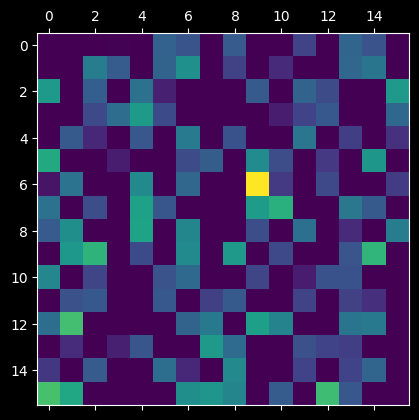

In [118]:
plt.matshow(network.self_attn.q_proj.weight.data.cpu()[:16][:,:16].float().abs())

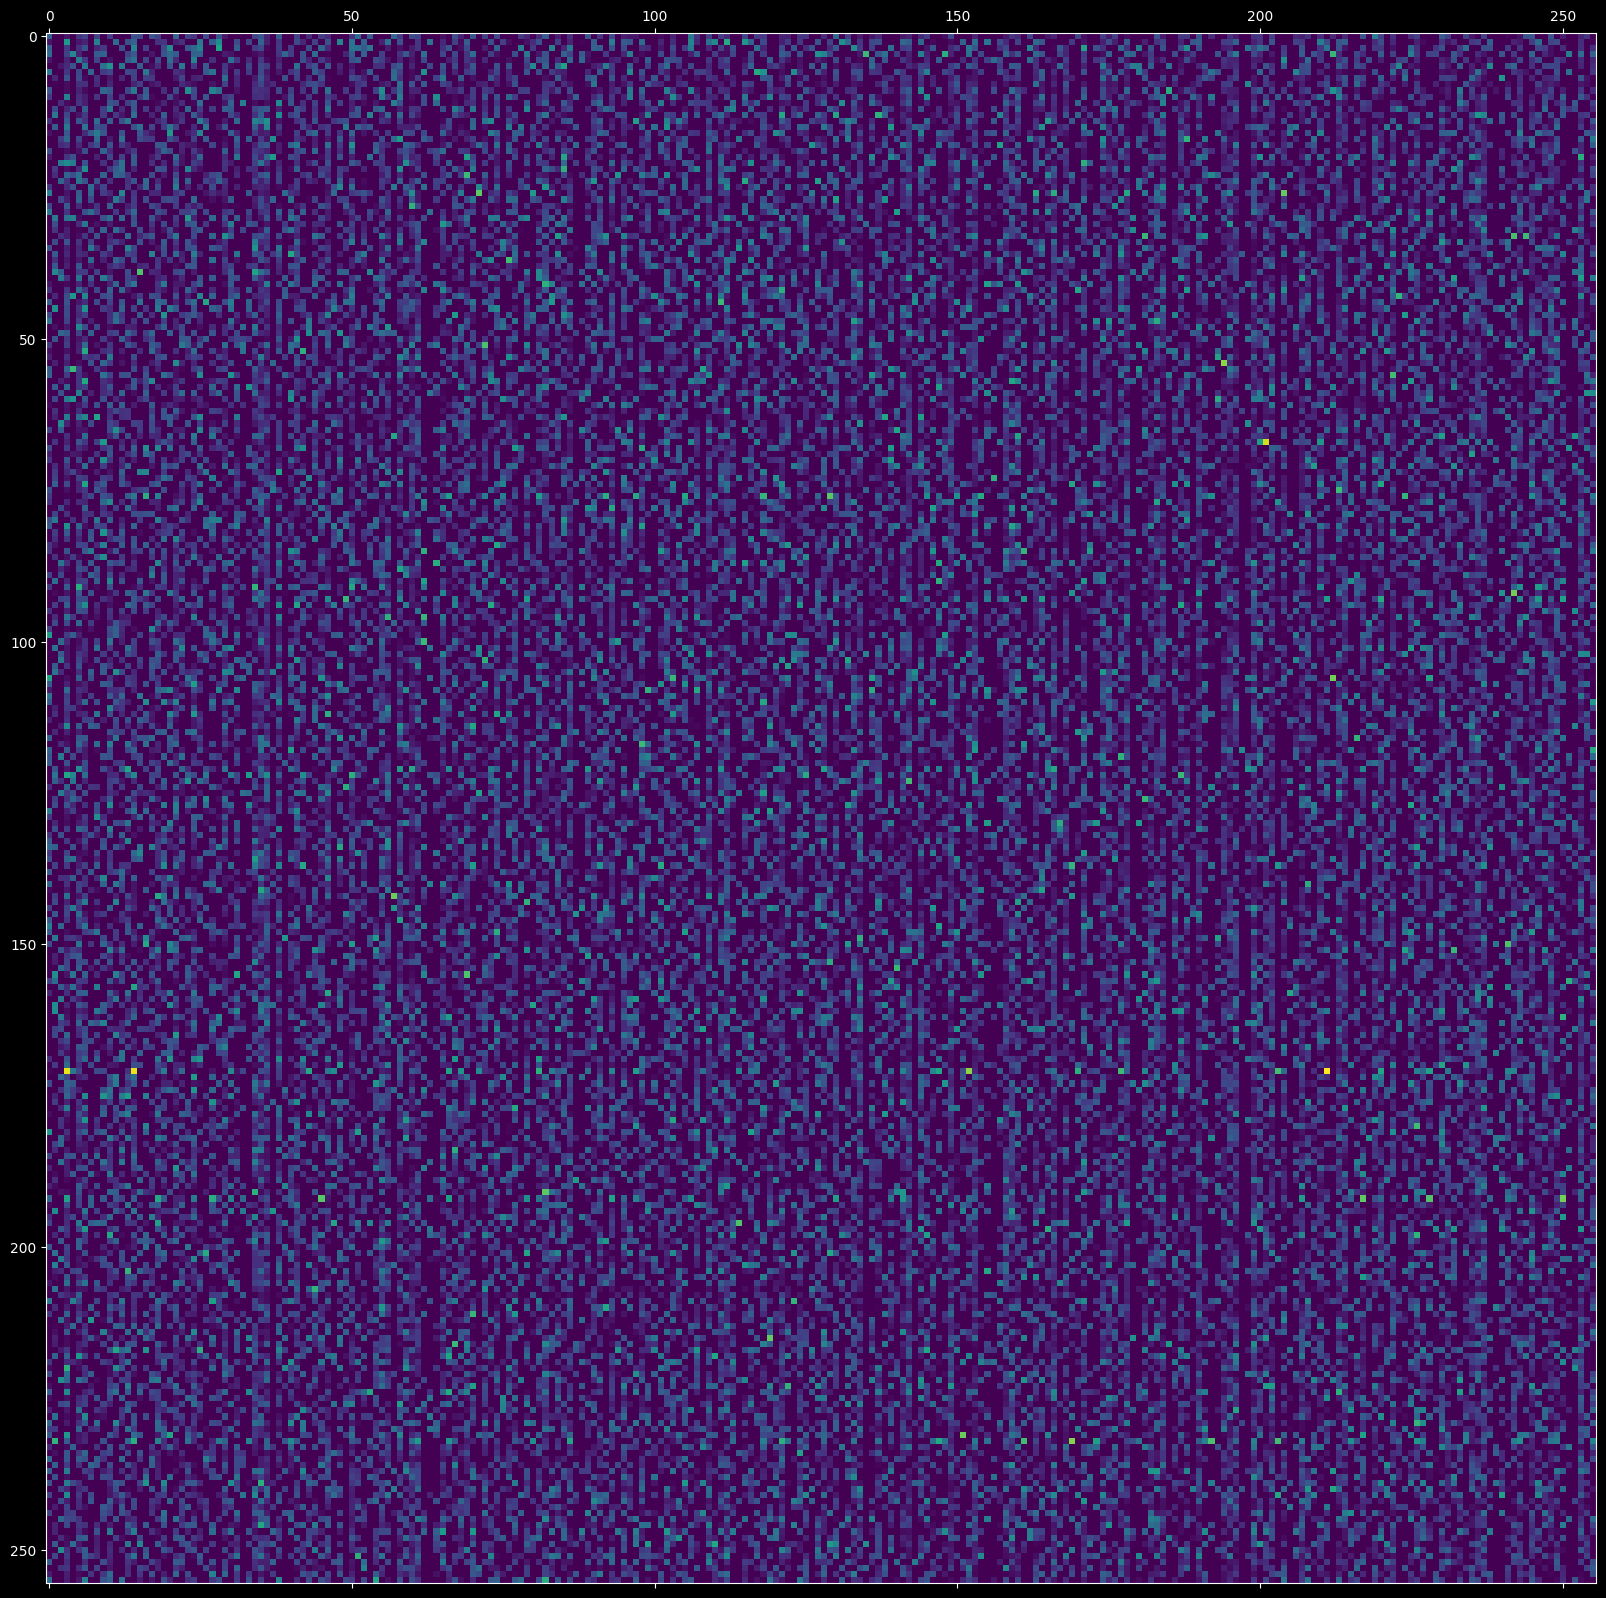

In [119]:
plt.figure(figsize=(20,20))
plt.matshow(network.mlp.down_proj.weight.data.cpu().float()[:256][:,:256].abs(),fignum=1)
plt.show()

In [130]:
for g in groups:
    g.hard_threshold(num_nz=2)

In [111]:
# student.model.layers[0].self_attn.q_proj.weight.grad*1e-35

In [94]:
np.mean([g.nnz()/g.numel for g in groups])

np.float64(0.49999992336545673)

In [108]:
for n,p in student.named_parameters():
    if "proj" in n:
        print(n, ((p.data.abs()> 1e-12).sum()/p.numel()).item())

model.layers.0.self_attn.q_proj.weight 0.5
model.layers.0.self_attn.k_proj.weight 0.5
model.layers.0.self_attn.v_proj.weight 0.5
model.layers.0.self_attn.o_proj.weight 0.5
model.layers.0.mlp.gate_proj.weight 0.5
model.layers.0.mlp.up_proj.weight 0.5
model.layers.0.mlp.down_proj.weight 0.5
model.layers.1.self_attn.q_proj.weight 0.5
model.layers.1.self_attn.k_proj.weight 0.5
model.layers.1.self_attn.v_proj.weight 0.5
model.layers.1.self_attn.o_proj.weight 0.5
model.layers.1.mlp.gate_proj.weight 0.5
model.layers.1.mlp.up_proj.weight 0.5
model.layers.1.mlp.down_proj.weight 0.5
model.layers.2.self_attn.q_proj.weight 0.5
model.layers.2.self_attn.k_proj.weight 0.5
model.layers.2.self_attn.v_proj.weight 0.5
model.layers.2.self_attn.o_proj.weight 0.5
model.layers.2.mlp.gate_proj.weight 0.5
model.layers.2.mlp.up_proj.weight 0.5
model.layers.2.mlp.down_proj.weight 0.5
model.layers.3.self_attn.q_proj.weight 0.5
model.layers.3.self_attn.k_proj.weight 0.5
model.layers.3.self_attn.v_proj.weight 0.5
m

In [27]:
prompt = "Give me a brief explanation of gravity in simple terms."
messages_think = [
    {"role": "user", "content": prompt}
]

text = tokenizer.apply_chat_template(
    messages_think,
    tokenize=False,
    add_generation_prompt=True,
)
model_inputs = tokenizer([text], return_tensors="pt").to(teacher.device)

# Generate the output
generated_ids = teacher.generate(**model_inputs, max_new_tokens=2048)

# Get and decode the output
output_ids = generated_ids[0][len(model_inputs.input_ids[0]) :]
print(tokenizer.decode(output_ids, skip_special_tokens=True))

<think>
Okay, the user wants a brief explanation of gravity in simple terms. Let me start by recalling what I know about gravity. It's a force that attracts objects with mass towards each other. But how do I explain that simply?

Maybe start with the basic idea that everything with mass pulls on everything else. But I should avoid jargon. Use everyday examples, like why we stay on the ground. Also, mention that the more mass an object has, the stronger its gravitational pull. But I need to keep it short. Should I mention Newton's law of universal gravitation? Maybe not too detailed. Also, perhaps touch on Einstein's theory of relativity briefly, but since it's simple terms, maybe just stick to Newton's explanation. Wait, the user said "simple terms," so maybe just the basics. Let me check if there's anything else. Oh, the concept of gravity as a force that keeps planets in orbit. Yeah, that's a good point. But keep it concise. Let me structure it: start with gravity as a force, mention

In [151]:
prompt = "Give me a brief explanation of gravity in simple terms."
messages_think = [
    {"role": "user", "content": prompt}
]

text = tokenizer.apply_chat_template(
    messages_think,
    tokenize=False,
    add_generation_prompt=True,
)
model_inputs = tokenizer([text], return_tensors="pt").to(student.device)

# Generate the output
generated_ids = student.generate(**model_inputs, max_new_tokens=2048)

# Get and decode the output
output_ids = generated_ids[0][len(model_inputs.input_ids[0]) :]
print(tokenizer.decode(output_ids, skip_special_tokens=True))

<think>
Okay, the user wants a brief explanation of gravity in simple terms. Let me start by recalling what I know about gravity. It's a force that attracts objects with mass towards each other. But how to explain that simply?

Maybe start with the basic idea that gravity is what keeps us on the ground and makes things fall. But I should mention that it's not just Earth's gravity. Maybe use an example like the Moon orbiting the Earth. Wait, but the user might not know about orbits. Hmm.

I should avoid technical terms like "mass" or "inertia" if possible. Wait, but mass is necessary. Maybe use everyday examples. Like when you drop something, it falls down. But why? Because gravity pulls it towards the Earth. But how does that work? Maybe compare it to a magnet, but gravity isn't like that. Maybe mention that it's a force that acts over a distance, but not as strong as a magnet.

Also, Einstein's theory of relativity says gravity is the curvature of spacetime, but that's more complex. T

In [152]:
optimizer.zero_grad(set_to_none=True)
# del optimizer
torch.cuda.empty_cache()

In [120]:
from lm_eval.tasks import TaskManager
from lm_eval.models import huggingface
from lm_eval.evaluator import simple_evaluate


hf_model = huggingface.HFLM(student, tokenizer=tokenizer)

task_manager = TaskManager()
with torch.no_grad():


    results = simple_evaluate(
        model=hf_model,
        tasks=["wikitext"],
        num_fewshot=0,
        task_manager=task_manager,
        log_samples=False,
        batch_size=2,
        # delete_requests_cache=True,
    )


print(results["results"])
del results
torch.cuda.empty_cache()

`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
[Task: wikitext] metric word_perplexity is defined, but aggregation is not. using default aggregation=weighted_perplexity
[Task: wikitext] metric word_perplexity is defined, but higher_is_better is not. using default higher_is_better=False
[Task: wikitext] metric byte_perplexity is defined, but aggregation is not. using default aggregation=weighted_perplexity
[Task: wikitext] metric byte_perplexity is defined, but higher_is_better is not. using default higher_is_better=False
[Task: wikitext] metric bits_per_byte is defined, but aggregation is not. using default aggregation=bits_per_byte
[Task: wikitext] metric bits_per_byte is defined, but higher_is_better is not. u

{'wikitext': {'alias': 'wikitext', 'word_perplexity,none': 12.500169766513576, 'word_perplexity_stderr,none': 'N/A', 'byte_perplexity,none': 1.6037207875411243, 'byte_perplexity_stderr,none': 'N/A', 'bits_per_byte,none': 0.6814229862481511, 'bits_per_byte_stderr,none': 'N/A'}}


In [80]:
task_manager = TaskManager()
with torch.no_grad():


    results = simple_evaluate(
        model=hf_model,
        tasks=["hellaswag"],
        task_manager=task_manager,
        log_samples=False,
        batch_size=2,
        # delete_requests_cache=True,
    )


print(results["results"])
del results
torch.cuda.empty_cache()

Running loglikelihood requests: 100%|██████████| 40168/40168 [35:02<00:00, 19.10it/s]


{'hellaswag': {'alias': 'hellaswag', 'acc,none': 0.5686118303126867, 'acc_stderr,none': 0.004942578520987334, 'acc_norm,none': 0.7474606652061342, 'acc_norm_stderr,none': 0.004335809614480291}}


In [28]:
from lm_eval.tasks import TaskManager
from lm_eval.models import huggingface
from lm_eval.evaluator import simple_evaluate


hf_model = huggingface.HFLM(teacher, tokenizer=tokenizer)

task_manager = TaskManager()
with torch.no_grad():


    results = simple_evaluate(
        model=hf_model,
        tasks=["wikitext"],
        num_fewshot=0,
        task_manager=task_manager,
        log_samples=False,
        # delete_requests_cache=True,
    )


print(results["results"])
del results
torch.cuda.empty_cache()

`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
[Task: wikitext] metric word_perplexity is defined, but aggregation is not. using default aggregation=weighted_perplexity
[Task: wikitext] metric word_perplexity is defined, but higher_is_better is not. using default higher_is_better=False
[Task: wikitext] metric byte_perplexity is defined, but aggregation is not. using default aggregation=weighted_perplexity
[Task: wikitext] metric byte_perplexity is defined, but higher_is_better is not. using default higher_is_better=False
[Task: wikitext] metric bits_per_byte is defined, but aggregation is not. using default aggregation=bits_per_byte
[Task: wikitext] metric bits_per_byte is defined, but higher_is_better is not. u

{'wikitext': {'alias': 'wikitext', 'word_perplexity,none': 12.21292061236587, 'word_perplexity_stderr,none': 'N/A', 'byte_perplexity,none': 1.5967638270712277, 'byte_perplexity_stderr,none': 'N/A', 'bits_per_byte,none': 0.675150943488172, 'bits_per_byte_stderr,none': 'N/A'}}


In [59]:
for p_s, p_t in zip(student.parameters(), teacher.parameters()):
    mask = (p_s.data.abs()>0)
    p_s.data.copy_(p_t.data)
    p_s.data.mul_(mask)

In [52]:
for g in groups:
    print(g.nnz()/g.numel)

0.8972702026367188
0.9430499076843262
0.9720439910888672
0.9614696502685547
0.8927122751871744
0.9104450543721517
0.9329125881195068
0.867070198059082
0.9119582176208496
0.947108268737793
0.9419543743133545
0.815058708190918
0.8814824422200521
0.8743852774302164
0.8565797805786133
0.9032082557678223
0.9477190971374512
0.9393625259399414
0.8835160732269287
0.999999205271403
0.9999996026357015
0.9999997615814209
1.0
0.9999995231628418
0.9999997615814209
0.9999992847442627
0.9999996026357015
0.9999997615814209
1.0
1.0
0.9999990463256836
1.0
0.9999994436899821
0.9999998410542806
0.9999997615814209
0.9999992847442627
1.0
1.0
0.9999992847442627
0.9999998410542806
0.9999998410542806
0.9999998410542806
1.0
1.0
1.0
0.9999997615814209
0.9999998410542806
0.9999996026357015
0.9999997615814209
0.9999997615814209
0.9999995231628418
1.0
1.0
0.9999998410542806
0.9999993642171224
0.9999996821085612
0.9999997615814209
0.9999995231628418
1.0
0.9999995231628418
0.9999996821085612
0.9999999205271403
0.9999

In [59]:
with torch.no_grad():
    pbar = tqdm(range(len(tokenized_inputs)), desc=f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0.0
    num_batches = 0
    for idx in pbar:
        model_inputs = tokenized_inputs[idx]
        num_batches += 1
        target = target_logits[idx].to(student.device)
        target = target.view(-1, target.shape[-1])
        pred = student(**model_inputs.to(student.device), labels=None).logits
        pred = pred.view(-1, pred.shape[-1])


        loss = criterion(pred, target)
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{total_loss / num_batches:.6f}", density = np.mean([g.nnz()/g.numel for g in groups]))

Epoch 2/10: 100%|██████████| 128/128 [00:10<00:00, 11.78it/s, density=0.5, loss=9.617188]
